# 1  Taxi demand prediction in New York City


# 2  Objective
<p><b> Time-series forecasting and Regression</b></p>
<br>
- To predict number of pickups, given location cordinates(latitude and longitude) and time
- Jan - Mar 2015 data used to predict the pickups in Jan - Mar 2016.
- Use Discrete Fourier Transform to add features to Regression models
- Tune the Hyper-Parameters to improve the models
- Experiment with different time series featurization techniques to reduce MAPE below 12%


## 2.1  Performance metrics
1. Mean Absolute percentage error(MAPE)
2. Mean Squared error.

# 3  Data Information

## 3.1  Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> NYC yellow taxis provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC.</p>

## 3.2  Data Collection
We Have collected all yellow taxi trips data from jan to march for the years 2015,2016 <br>
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml <br>
<table>
<tr>
<th> file name </th>
<th> file name size</th>
<th> number of records </th>
<th> number of features </th>
</tr>
<tr>
<td> yellow_tripdata_2016-01 </td>
<td> 1. 59G </td>
<td> 10906858 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-02 </td>
<td> 1. 66G </td>
<td> 11382049 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-03 </td>
<td> 1. 78G </td>
<td> 12210952 </td>
<td> 19 </td>
</tr>


<tr>
<td> yellow_tripdata_2015-01 </td>
<td> 1.84Gb </td>
<td> 12748986 </td>
<td> 19 </td>
</tr>


# 4  Importing Required Packages

In [1]:
import dask.dataframe as dd #similar to pandas
import pandas as pd
import folium #open street map

import datetime 
import time 
import numpy as np


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import StandardScaler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams#Size of plots  
# distance between two (lat,lon) pairs in miles
import gpxpy.geo

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import scipy

mingw_path = 'C:\\MinGW\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from termcolor import colored
import peakutils
from peakutils.plot import plot as pplot
import warnings
warnings.filterwarnings("ignore")

<br>
Note: dask data-frame is used below not pandas

In [2]:
# dask dataframe
print('loading January 2015 data\n')
jan_2015 = dd.read_csv('G:\data\y_taxi\yellow_tripdata_2015-01.csv')
print(jan_2015.columns)

loading January 2015 data

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# 5  Exploratory Data Analysis

In this section we will be doing<b style= "color:blue"> univariate analysis </b>and explore the posibility of outliers/errorneous points 

## 5.1  Features in the dataset

In [3]:
print(jan_2015.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [4]:
print('few of the jan 2015 data points\n')
print(jan_2015.head(5))
# observe the 19 attributes

few of the jan 2015 data points

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.97478

## 5.2  Pickup locations

 New York is bounded by the cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) <br>
 source https://www.flickr.com/places/info/2459115  <br>
 <br>
hence any pickup cordinates outside of range is removed.

### 5.2.1 Plotting pickup outliers

In [3]:
# all the points outside newyork city to pickup_outliers
pickup_outliers = jan_2015[((jan_2015.pickup_longitude <= -74.15) | (jan_2015.pickup_latitude <= 40.5774)| \
                   (jan_2015.pickup_longitude >= -73.7004) | (jan_2015.pickup_latitude >= 40.9176))]

# creating a map with the a base location
map_1 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# plot first 10000 outliers on map
sample_1 = pickup_outliers.head(10000)

for i,j in sample_1.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_1)
        
map_1

<b>Observation:-</b> some points are just outside the boundary but there are some in South america, Mexico or Canada or even in the ocean

## 5.3 Dropoff locations

Similar to pick ups we will consider drop offs outside the cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) as outliers

### 5.3.1 Plotting drop-off outliers

In [4]:
# call the points outside newyork city to dropoff_outliers
dropoff_outliers = jan_2015[((jan_2015.dropoff_longitude <= -74.15)   |  \
                             (jan_2015.dropoff_latitude <= 40.5774)   |  \
                             (jan_2015.dropoff_longitude >= -73.7004) |  \
                             (jan_2015.dropoff_latitude >= 40.9176))]

# creating a map with the a base location

map_2 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# plot first 10000 outliers on the map
sample_2 = dropoff_outliers.head(10000)
for i,j in sample_2.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_2)
map_2

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

## 5.4  Create New DataFrame :
Dataframe with required features

In [5]:
# calculation of speed,trip duration and binning pickup-times will be easy in unix timestamp 

def To_unix(s):
    '''YYYY-MM-DD HH:MM:SS to unix timestamp'''
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [6]:
def create_df(month):
    '''
    #########################################################################################

    #   Returns a data frame which contains the columns
    # 1.'passenger_count' : self explanatory
    # 2.'trip_distance' : self explanatory
    # 3.'pickup_longitude' : self explanatory
    # 4.'pickup_latitude' : self explanatory
    # 5.'dropoff_longitude' : self explanatory
    # 6.'dropoff_latitude' : self explanatory
    # 7.'total_amount' : total fair that was paid
    # 8.'trip_times' : duration of each trip
    # 9.'pickup_times : pickup time converted into unix time 
    # 10.'Speed' : velocity of each trip

    #########################################################################################
    '''
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    #pickups and dropoffs to unix time
    pickup_time = [To_unix(x) for x in duration['tpep_pickup_datetime'].values]
    dropoff_time = [To_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    #calculate trip duration= dropoff-pickoff
    # divide by 60 to convert seconds to minutes
    
    durations = (np.array(dropoff_time) - np.array(pickup_time)) / float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude'
                       ,'dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = pickup_time
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

In [7]:
new_df = create_df(jan_2015)

In [8]:
print(new_df.columns)

Index(['passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'total_amount', 'trip_times', 'pickup_times', 'Speed'],
      dtype='object')


## 5.5  Trip Durations:

According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b><br>
<b style= "color:green">so no need check for extreme points, </b><br>just remove points with trip duration more than 12 hours<br>
also remove negative points as duration can't be negative

In [9]:
#removing data based on our analysis and TLC regulations
clean_df = new_df[(new_df.trip_times>1) & (new_df.trip_times<720)]

<IPython.core.display.Javascript object>


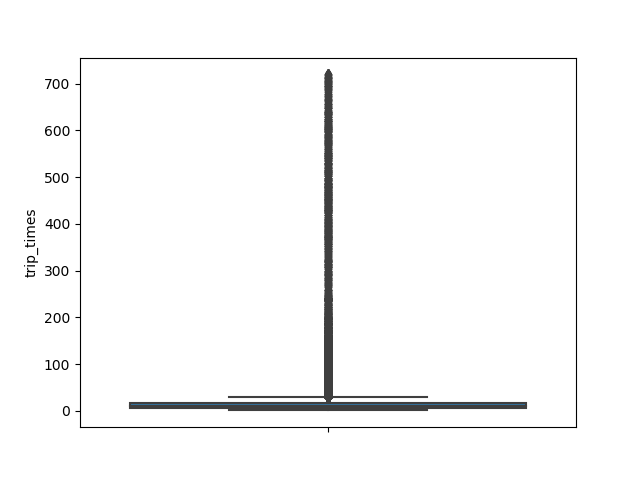

In [10]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data = clean_df)
plt.show()

<IPython.core.display.Javascript object>


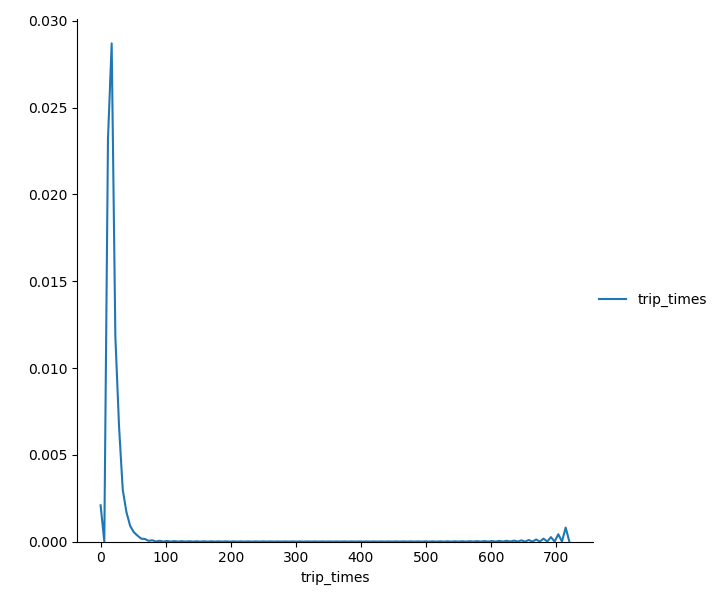

In [10]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(clean_df,size=6).map(sns.kdeplot,"trip_times").add_legend()
plt.show()


PDF plot is skewed

In [11]:
#converting the values to log-values to check for log-normal
# adding the attribute to df clean_df

clean_df['log_times']=[math.log(i) for i in clean_df['trip_times'].values]

<IPython.core.display.Javascript object>


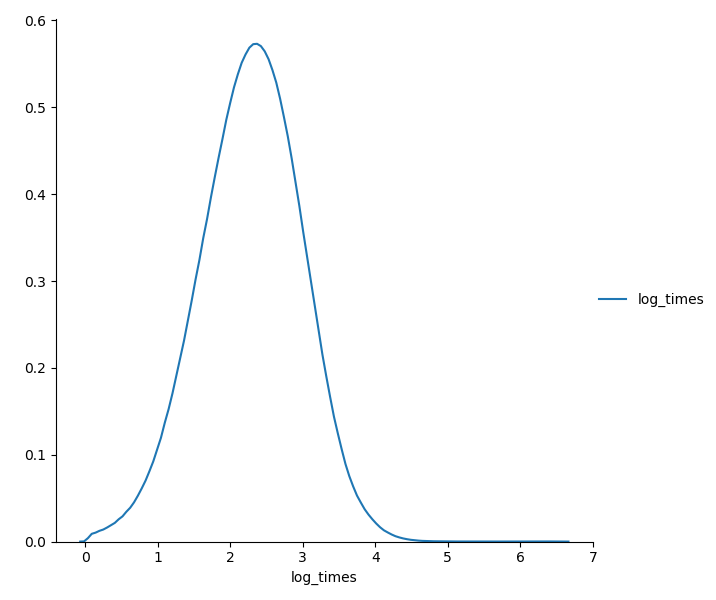

In [12]:
#pdf of log-values
sns.FacetGrid(clean_df,size=6).map(sns.kdeplot,"log_times").add_legend()
plt.show()
# is it Gaussian?

<IPython.core.display.Javascript object>


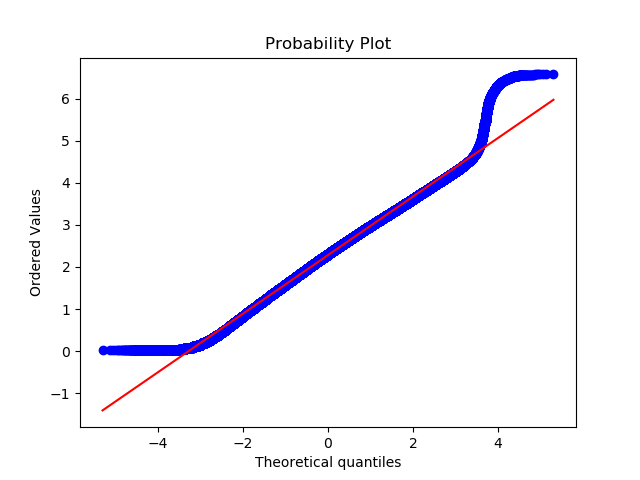

In [13]:
#Q-Q plot for checking if trip-times is log-normal

scipy.stats.probplot(clean_df['log_times'].values, plot=plt)
plt.show()
# Not gaussian

## 5.6  Speed:
in Miles/hour

<IPython.core.display.Javascript object>


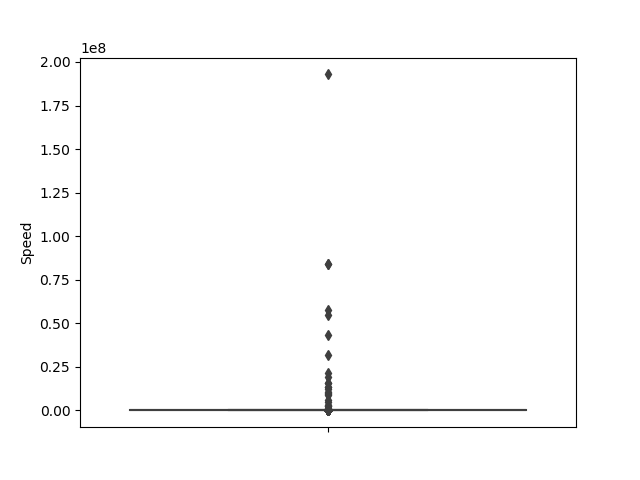

In [14]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
clean_df['Speed'] = (clean_df['trip_distance'] / clean_df['trip_times']) * 60

sns.boxplot(y="Speed", data = clean_df)
plt.show()

Box plot suggests there are outlier points

In [15]:
#calculating speed values for percntiles 95 to 100

for i in range(95,100):
    var = clean_df["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


**99 percentile value of average speed of about 35.75 Mph is reasonable but 100th percentile has crazy value**

In [16]:
#calculating speed values between percntile 99 to 100
for i in np.arange(0.0, 1.0, 0.1):
    var = clean_df["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [17]:
#removing further outliers based on the 99.9th percentile value
clean_df = new_df[(new_df.Speed > 0) & (new_df.Speed < 45.31)]

In [18]:
#avg.speed of cabs in New-York
sum(clean_df["Speed"]) / float(len(clean_df["Speed"]))

12.450173996027528

** The avg speed for yellow cab in Newyork speed is 12.45 Miles/hr,<br>
so a cab driver can travel 2 miles per 10min on avg.**

## 5.7  Trip Distance
in Miles

<IPython.core.display.Javascript object>


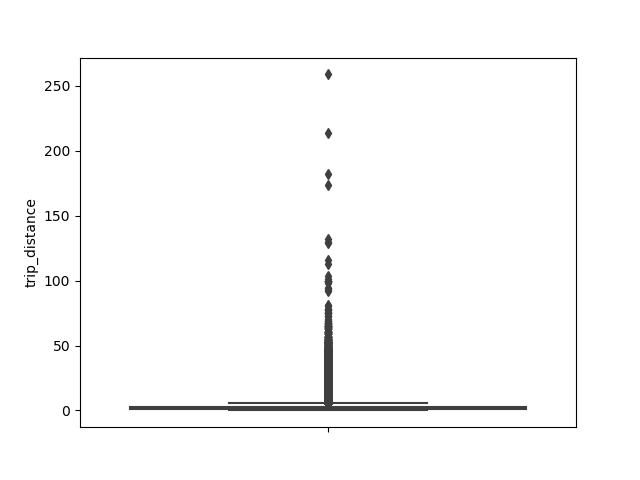

In [19]:
# box-plot showing outliers in trip-distance values

sns.boxplot(y="trip_distance", data = clean_df)
plt.show()

In [20]:
#calculating trip distance values at each percntile 90 to 100 
for i in range(90,100,1):
    var = clean_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [21]:
#calculating trip distance values for percntile between 99 and 100
for i in np.arange(0.0, 1.0, 0.1):
    var = clean_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [22]:
#removing further outliers based on the 99.9th percentile value
clean_df = new_df[(new_df.trip_distance>0) & (new_df.trip_distance < 23)]

<IPython.core.display.Javascript object>


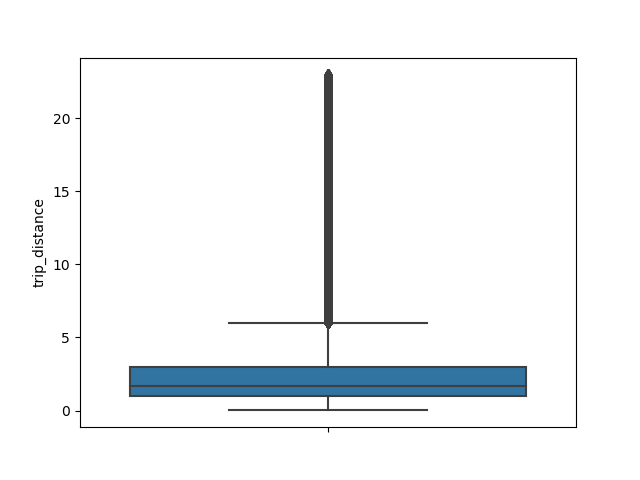

In [23]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = clean_df)
plt.show()

## 5.8  Total Fare
in US Dollars

<IPython.core.display.Javascript object>


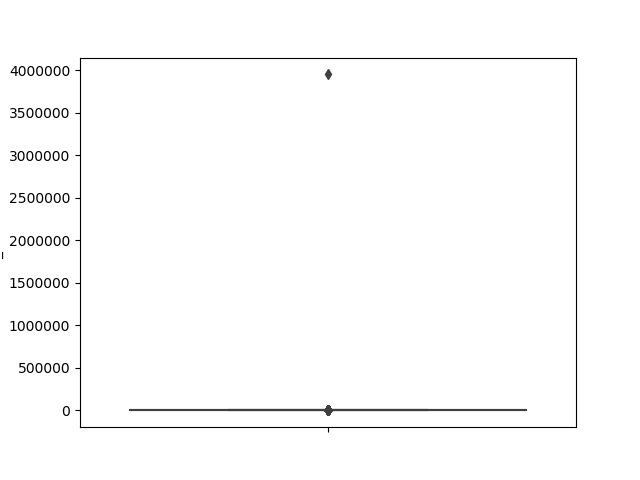

In [24]:
# we have removed the outliers based on trip durations, cab speeds, and trip distances

# box-plot showing outliers in fare amount
sns.boxplot(y="total_amount", data =new_df)
plt.show()

In [29]:
#calculating total fare amount values for percentiles 90 to 100
for i in range(90,100):
    var = clean_df["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


** 100th percentile has crazy value for cab fare of 3950611.6 Dollars**

In [25]:
#calculating fare amount between percntile 99 to 100
for i in np.arange(0.0, 1.0, 0.1):
    var = clean_df["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


**As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis **

<IPython.core.display.Javascript object>


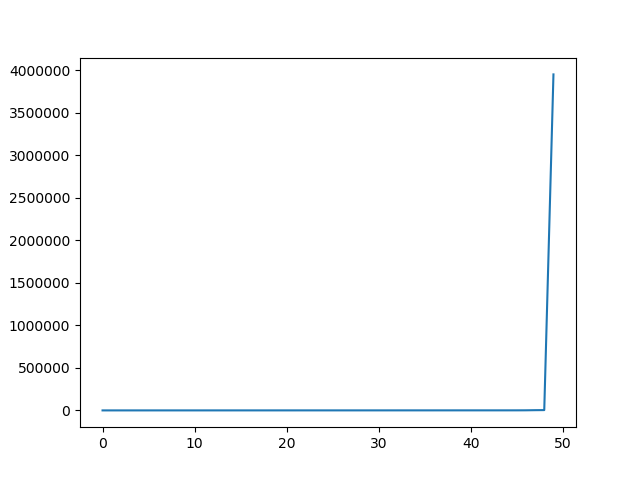

In [31]:
#below plot shows us the fare values(sorted) to 
#find a sharp increase to remove those values as outliers
# plot the 50 higest fare amounts 
plt.plot(var[-50:])
plt.show()

<IPython.core.display.Javascript object>


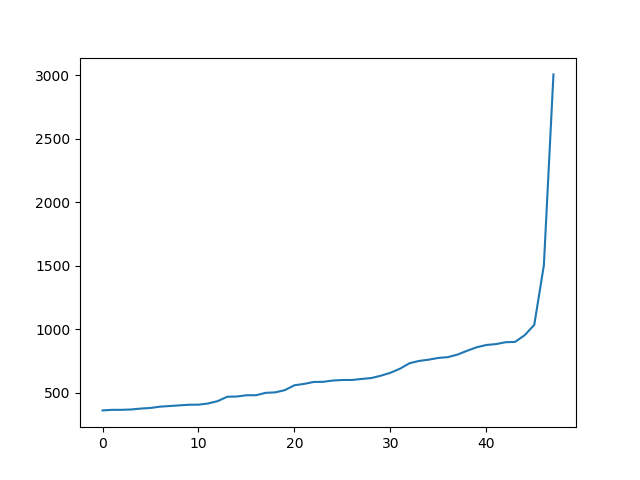

In [26]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

<font color='blue'>1000 dollars seems a good cutoff for fare<font>

In [27]:
clean_df = clean_df[(clean_df.total_amount>0) & (clean_df.total_amount<1000)]

# 6  Remove all outliers/erronous points.

**using the observation of EDA section we define the following function to clean data**

In [11]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_df):
    
    a = new_df.shape[0]
    print ("Number of pickup records = ",a)
    
#######################################################################################################
    
    new_frame = new_df[((new_df.dropoff_longitude >= -74.15) & (new_df.dropoff_longitude <= -73.7004) &  \
                      (new_df.dropoff_latitude >= 40.5774) & (new_df.dropoff_latitude <= 40.9176)) &   \
                      ((new_df.pickup_longitude >= -74.15) & (new_df.pickup_latitude >= 40.5774)&      \
                      (new_df.pickup_longitude <= -73.7004) &  (new_df.pickup_latitude <= 40.9176))]
 
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print("--- \n")
    return new_frame

In [12]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
clean_df = remove_outliers(new_df)
print("fraction of data points remaining after removing outliers",(len(clean_df)/len(new_df)))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Total outliers removed 377910
--- 

fraction of data points remaining after removing outliers 0.9703576425607495


In [15]:
clean_df.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

# 7  Data-preperation/Featurization
## 7.1  Clustering/Segmentation

In [13]:
# function for clustering

def find_regions(k):
    ''' number of clusters = k'''
    ''' returns cluster centers'''
    ''' each cluster represents a region'''
    
    kmeans = MiniBatchKMeans(n_clusters= k, batch_size=10000,random_state=42).fit(coords)
    
    cluster_centers = kmeans.cluster_centers_
    NumOfCluster = len(cluster_centers)
    return cluster_centers, NumOfCluster

In [14]:
# function to find distance between cluster

def min_distance(cluster_centers, n_clusters):
    '''number of cluster = n_clusters'''
    '''distances between regions are calculated as
       the distance between corresponding cluster centers'''
    
    # for any given region(cluster)
    # nice_points temp variable stores num of regions within radius 2 miles
    # bad_points temp variable stores num of regions not within 2 miles radius 
    nice_points = 0  
    bad_points = 0
    less2 = [] # store nice_points for each cluster
    more2 = [] # store bad points for each cluster
    min_dist=1000
    for i in range(0, n_clusters):
        
        nice_points = 0
        bad_points = 0
        
        for j in range(0, n_clusters):
            
            if j!=i:
                
                # gpxpy.geo gives distance between two latitudes and longitudes in meters
                # syntax: gpxpy.geo.haversine_distance(lat_1, long_1, lat_2, long_2)
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],
                                                        cluster_centers[j][0],cluster_centers[j][1])
                
                # 1 Mile = 1609.34 meter
                min_dist = min(min_dist,distance/(1609.34))
                if (distance/(1609.34)) <= 2:
                    nice_points +=1
                else:
                    bad_points += 1
                    
        less2.append(nice_points)
        more2.append(bad_points)
        
    neighbours.append(less2)
    print(colored("\n If Number of clusters: {}".format(n_clusters),'green'))
    print("Avg. Number of Clusters within 2 Miles radius: ", np.ceil(sum(less2)/len(less2)))
    print("Avg. Number of Clusters NOT within 2 Miles radius: ",np.ceil(sum(more2)/len(more2)))
    print("Min inter-cluster distance = ",min_dist,"\n","---"*10)



In [15]:
#trying different cluster sizes to choose the right K in K-means
coords = clean_df[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

# choose number of clusters such that, more num of clusters are close to any cluster center
# at the same time make sure that the minimum inter cluster dist should not be very less

for increment in range(10, 100, 10):
    cluster_centers, NumOfClusters = find_regions(increment)
    min_distance(cluster_centers, NumOfClusters)            


 If Number of clusters: 10
Avg. Number of Clusters within 2 Miles radius:  2.0
Avg. Number of Clusters NOT within 2 Miles radius:  8.0
Min inter-cluster distance =  1.0945442325142543 
 ------------------------------

 If Number of clusters: 20
Avg. Number of Clusters within 2 Miles radius:  4.0
Avg. Number of Clusters NOT within 2 Miles radius:  16.0
Min inter-cluster distance =  0.7131298007387813 
 ------------------------------

 If Number of clusters: 30
Avg. Number of Clusters within 2 Miles radius:  8.0
Avg. Number of Clusters NOT within 2 Miles radius:  22.0
Min inter-cluster distance =  0.5185088176172206 
 ------------------------------

 If Number of clusters: 40
Avg. Number of Clusters within 2 Miles radius:  8.0
Avg. Number of Clusters NOT within 2 Miles radius:  32.0
Min inter-cluster distance =  0.5069768450363973 
 ------------------------------

 If Number of clusters: 50
Avg. Number of Clusters within 2 Miles radius:  12.0
Avg. Number of Clusters NOT within 2 Miles r


**The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster), between the clusters which we got was 30**

In [16]:
# for k= 50 clusters the Min inter-cluster distance only 0.3 miles apart from each other
# for k= 30 and 40 there Min inter-cluster distance is about 0.5 miles
# Avg. Number of Clusters within 2 Miles radius = 8 is also same for 30 and 40
# but Avg. Number of Clusters NOT within 2 Miles radius is less for k=30 than k = 40
# So we choose 30 clusters for solve the further problem
# Getting 30 clusters using the kmeans 

kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)

# columns 'pickup_cluster' added 
clean_df['pickup_cluster'] = kmeans.predict(clean_df[['pickup_latitude', 'pickup_longitude']])

In [17]:
cluster_centers = kmeans.cluster_centers_
NumOfClusters = len(cluster_centers)

## 7.2  Plotting the cluster centers:

In [18]:
# Plotting the cluster centers on OSM

map_3 = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

for i in range(NumOfClusters):
    
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])),           \
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))) \
                 .add_to(map_3)
map_3

## 7.3  Plotting the clusters:

In [22]:
#Visualising the clusters on a map
def plot_regions(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig = fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000],
               frame.pickup_latitude.values[:100000], s=5,
               c=frame.pickup_cluster.values[:100000], cmap='tab20')
    
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()



<IPython.core.display.Javascript object>


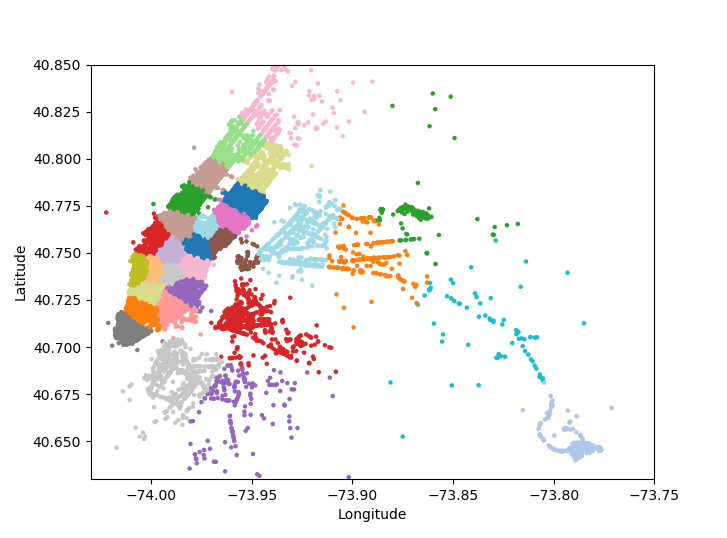

In [23]:
plot_regions(clean_df)

## 7.4  Time-binning

In [24]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00


def add_pickup_bins(frame,month,year):
    
    
    '''subtract pickup time from the unix time of 12:00AM for start of the month'''
    '''then divide that by 600 in order to make a 10minute bin'''

    unix_pick_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400],[1451606400,1454284800,1456790400]]
    
    unix_start_time = unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # +33 : our unix time is in gmt to we are converting it to est
    unix_binned_times=[(int((i-unix_start_time)/600)+33) for i in unix_pick_times]
    frame['pickup_bins'] = np.array(unix_binned_times)
    return frame

In [25]:
# column 'pickup_bins' added

jan_2015_frame = add_pickup_bins(clean_df,1,2015)
    
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']]\
                   .groupby(['pickup_cluster','pickup_bins']).count()

In [26]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              14         2130  
1  1.420902e+09   9.983193              25         1419  
2  1.420902e+09  10.746269               8         1419  
3  1.420902e+09  16.071429              21         1419  
4  1.420902e+09   9.318378              28         1419

In [27]:
# grouped data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (whole months into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      138
               2                      262
               3                      311
               4                      326
               5                      381

**we cleaned and prepared data for the month of Jan 2015**<br>
**now we will do that for all the months**

## 7.5  Prepare the whole data

In [28]:
# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required columns
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickup_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def data_prep(month,kmeans,month_no,year_no):
    
    print ("Return df with required columns only")

    new_df = create_df(month)
    
    print ("Remove outliers..")
    clean_df = remove_outliers(new_df)
    
    print ("Estimating clusters..")
    clean_df['pickup_cluster'] = kmeans.predict(clean_df[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupby..")
    final_frame = add_pickup_bins(clean_df, month_no, year_no)
    final_groupby_frame = final_frame[['pickup_cluster','pickup_bins','trip_distance']]\
                          .groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_frame, final_groupby_frame
    


In [29]:
month_jan_2016 = dd.read_csv('D:\Ai course\data\y_taxi\yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('D:\Ai course\data\y_taxi\yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('D:\Ai course\data\y_taxi\yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = data_prep(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = data_prep(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = data_prep(month_mar_2016,kmeans,3,2016)

Return df with required columns only
Remove outliers..
Number of pickup records =  10906858
Total outliers removed 297784
--- 

Estimating clusters..
Final groupby..
Return df with required columns only
Remove outliers..
Number of pickup records =  11382049
Total outliers removed 308177
--- 

Estimating clusters..
Final groupby..
Return df with required columns only
Remove outliers..
Number of pickup records =  12210952
Total outliers removed 324635
--- 

Estimating clusters..
Final groupby..


## 7.6  Smoothing

In [30]:
# Gets the unique bins where pickup values are present for  each region

# 
# observe that there are some pickpbins that doesnt have any pickups

def unq_pickup_bins(frame):
    '''the indices of all the unique time_bins where'''
    ''' there is a pickup for all the 30 clusters'''
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [31]:
# for each cluster collect all indices of 10min bins where pickups != 0
#jan
jan_2015_unique = unq_pickup_bins(jan_2015_frame)
jan_2016_unique = unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = unq_pickup_bins(mar_2016_frame)

In [32]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",\
          4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  26
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  150
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  170
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  40
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  320
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  35
----------

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [33]:
 
def fill_missing(count_values,values):
    '''Fills zero for every bin where no pickup data is present'''
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [34]:
# Fills a value of zero for every bin where no pickup data is present 

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data 
# we finally return smoothed data

def smoothing(count_values,values):
    
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for left-limit or pickup-bin value if present
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: last few values are missing,hence no right-limit present here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: missing values are between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: first few values are missing,hence no left-limit present here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [35]:
#Filling Missing values of Jan-2015 with 0
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [36]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 30*4464 = 133920 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  133920


when you are using smoothing we are looking at the future number of pickups which might cause a data leakage.
so we use smoothing for jan 2015th data since it acts as our training data
and we use simple fill_misssing method for 2016th data.


consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
and 20 pickups happened in 4th 10min intravel.
<br>
in fill_missing method we replace these values like 10, 0, 0, 20
where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
that are happened in the first 40 min are same in both cases, but if you can observe that we looking at the future values
<br>
when you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

In [37]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)


In [38]:


pickle_out = open("jan_2015_smooth.pickle","wb")
pickle.dump(jan_2015_smooth, pickle_out)
pickle_out.close()

pickle_out = open("jan_2016_smooth.pickle","wb")
pickle.dump(jan_2016_smooth, pickle_out)
pickle_out.close()

pickle_out = open("feb_2016_smooth.pickle","wb")
pickle.dump(feb_2016_smooth, pickle_out)
pickle_out.close()

pickle_out = open("mar_2016_smooth.pickle","wb")
pickle.dump(mar_2016_smooth, pickle_out)
pickle_out.close()

In [35]:

pickle_in = open("jan_2015_smooth.pickle","rb")
jan_2015_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("jan_2016_smooth.pickle","rb")
jan_2016_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("feb_2016_smooth.pickle","rb")
feb_2016_smooth = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("mar_2016_smooth.pickle","rb")
mar_2016_smooth = pickle.load(pickle_in)
pickle_in.close()


In [39]:


# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# smooth16:store 30 lists, each list contain 4464+4176+4464 values
# which represents the number of pickups for three months in 2016 data

# list of all the values of pickup data in every bin for a 3 months period of 2016
smooth16 = []
for i in range(0,30):
    smooth16.append(jan_2016_smooth[4464*i:4464*(i+1)]  \
                       +feb_2016_smooth[4176*i:4176*(i+1)] \
                       +mar_2016_smooth[4464*i:4464*(i+1)])

In [40]:
print(len(smooth16))
len(smooth16[0])

30


13104


## 7.7  Fourier Transforms

<b style= "color:#339966">**If time-series data has a repeating pattern then the Fourier decomposed frequencies and their amplitude can be added as a features to the data**</b> <br>

### 7.7.1  plot time series data 
plot and observe patterns,for each region and month to decide if Fourier Transform is useful

<IPython.core.display.Javascript object>


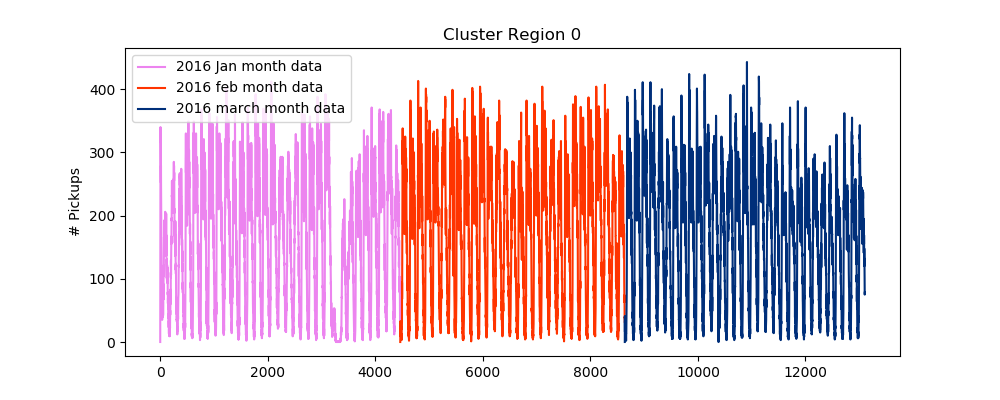

<IPython.core.display.Javascript object>


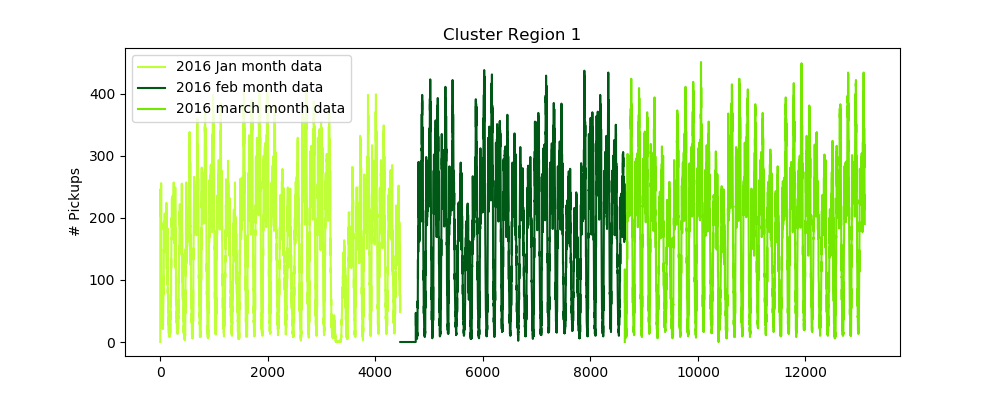

<IPython.core.display.Javascript object>


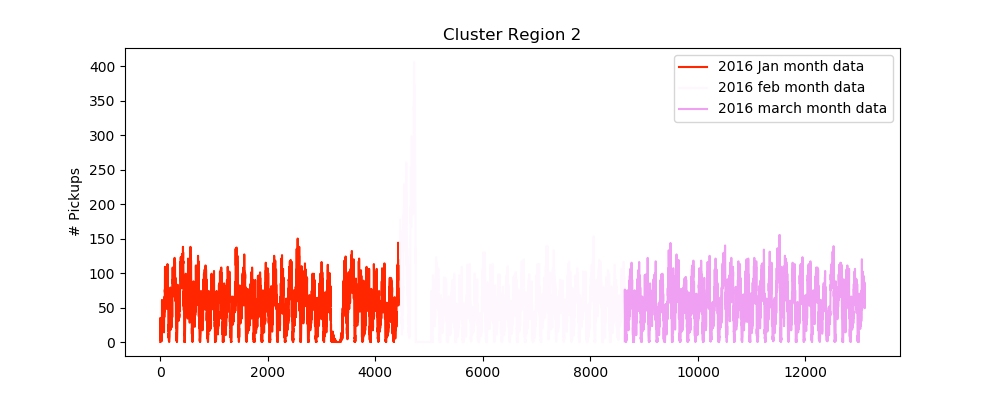

<IPython.core.display.Javascript object>


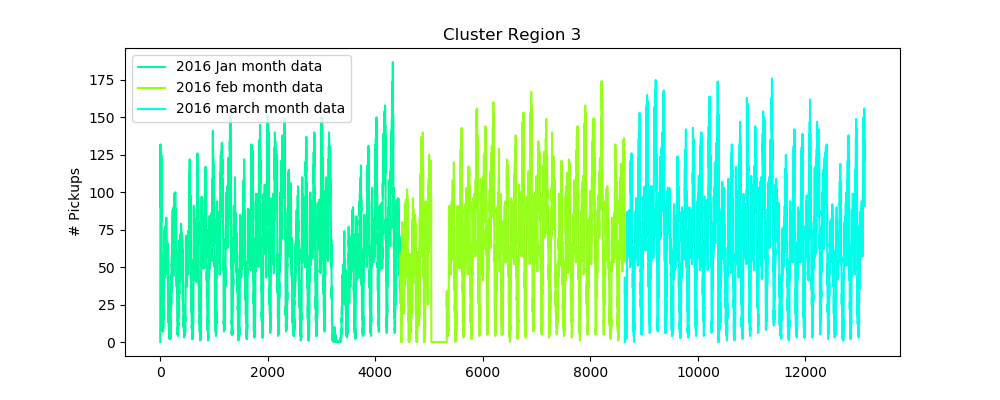

<IPython.core.display.Javascript object>


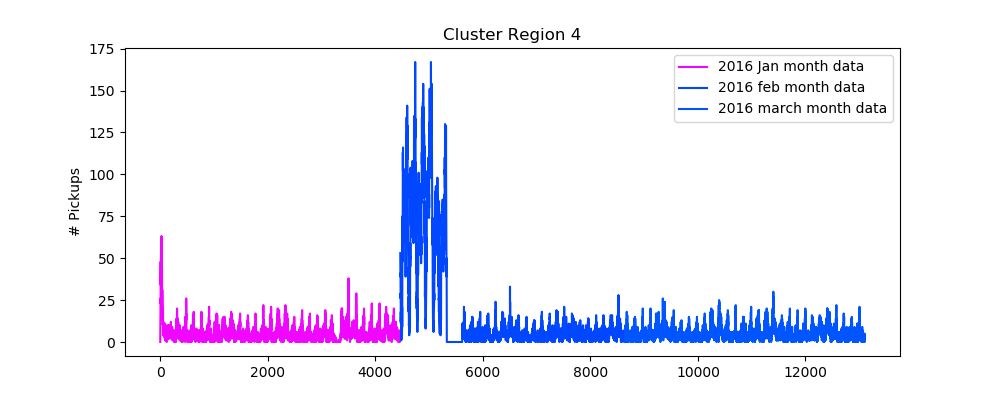

<IPython.core.display.Javascript object>


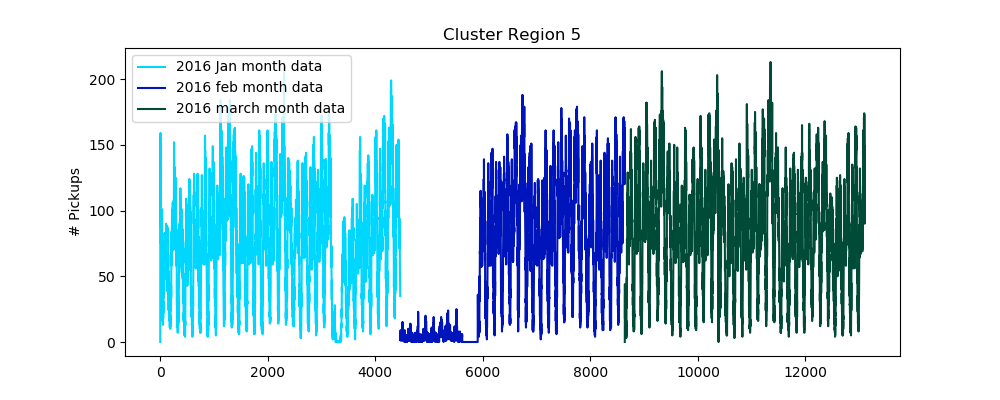

<IPython.core.display.Javascript object>


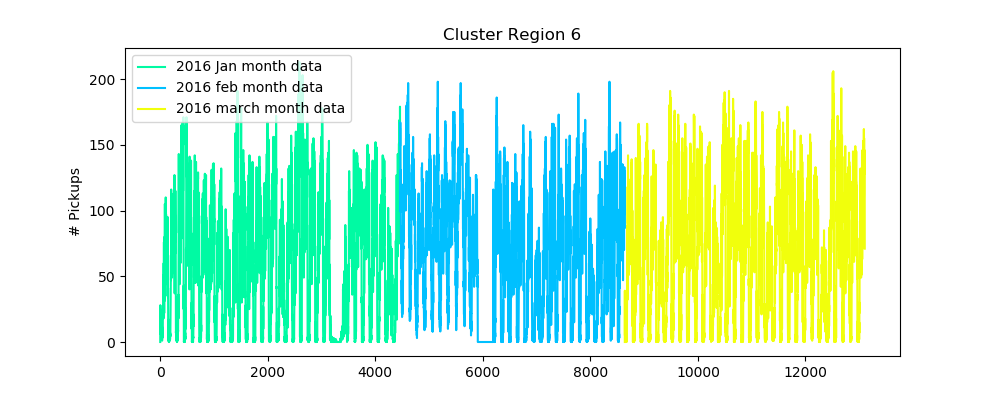

<IPython.core.display.Javascript object>


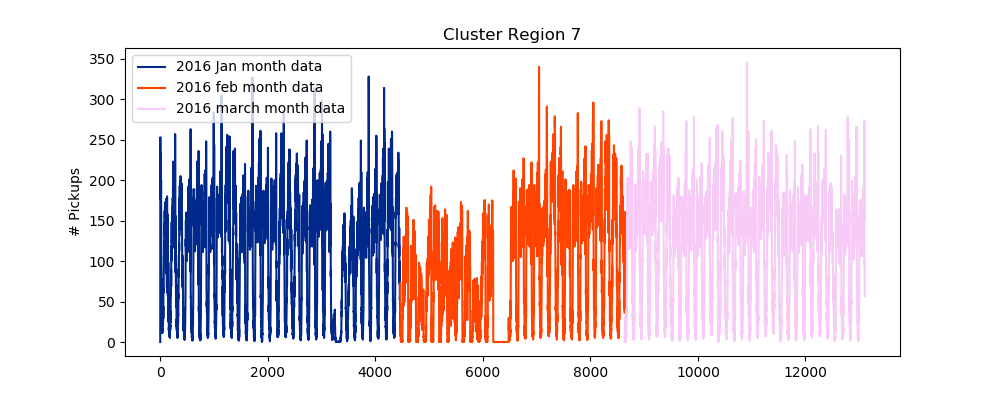

<IPython.core.display.Javascript object>


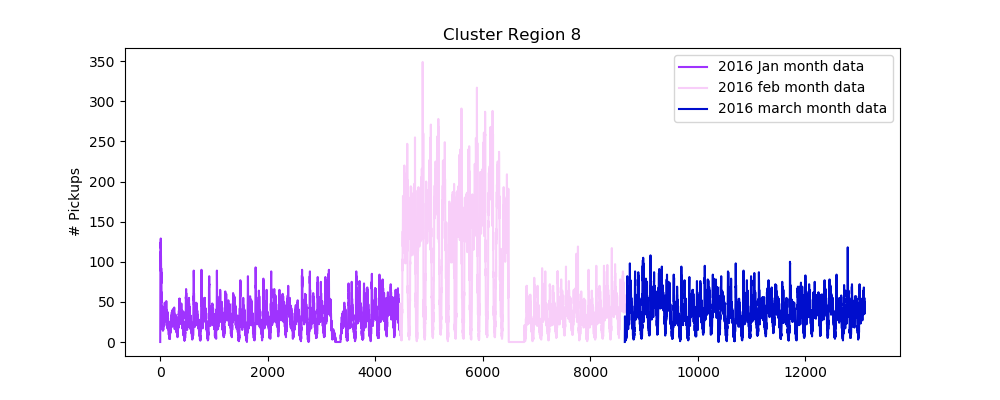

<IPython.core.display.Javascript object>


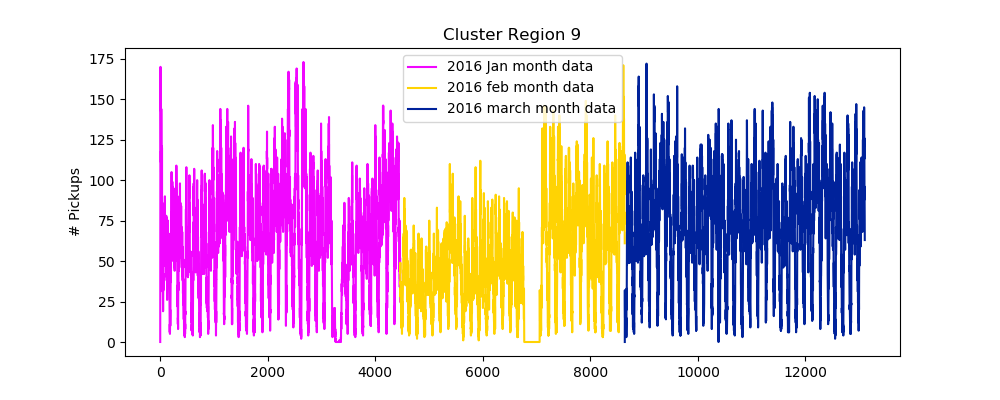

<IPython.core.display.Javascript object>


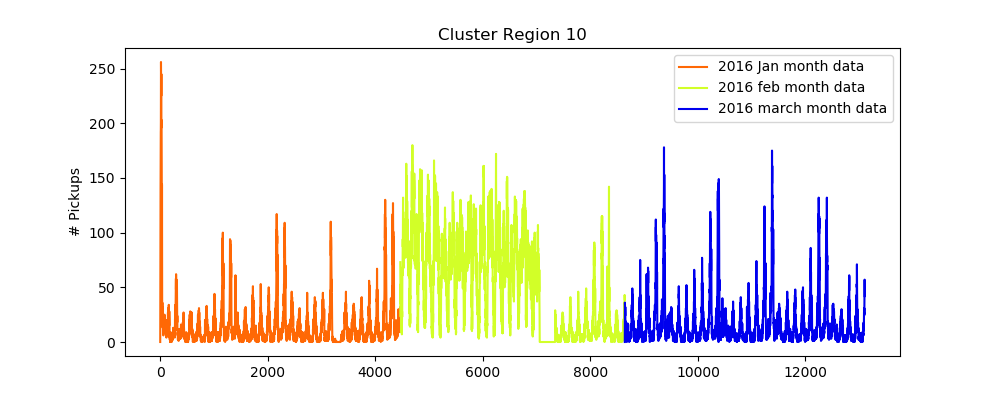

<IPython.core.display.Javascript object>


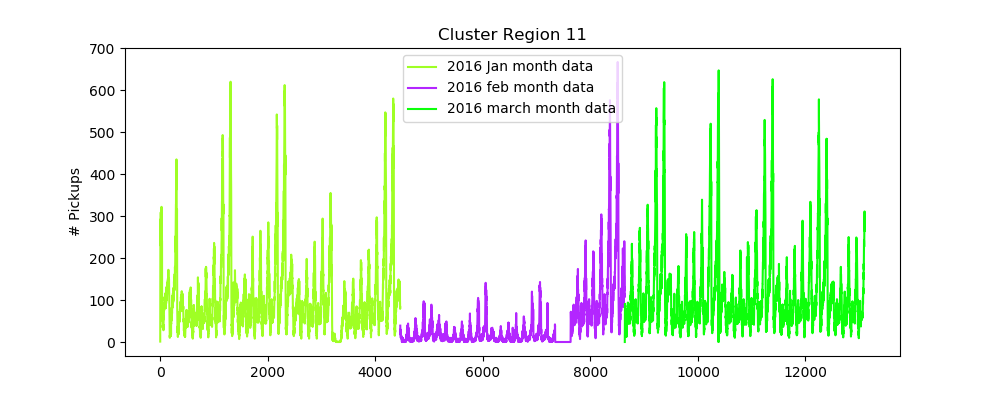

<IPython.core.display.Javascript object>


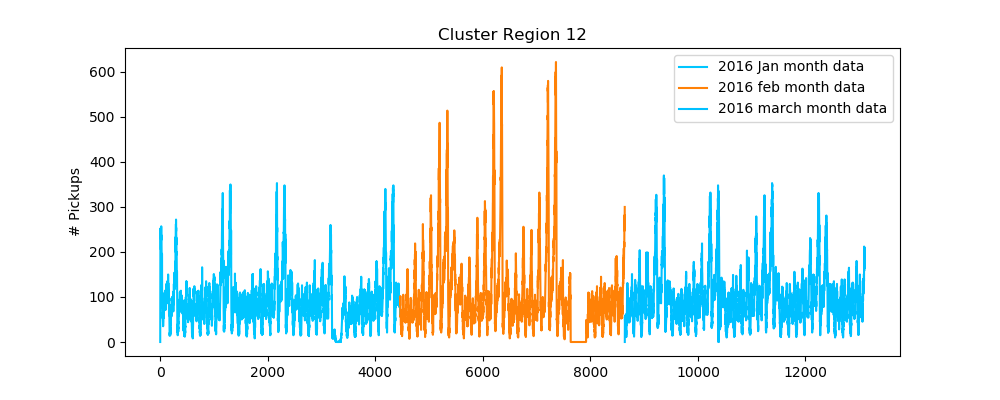

<IPython.core.display.Javascript object>


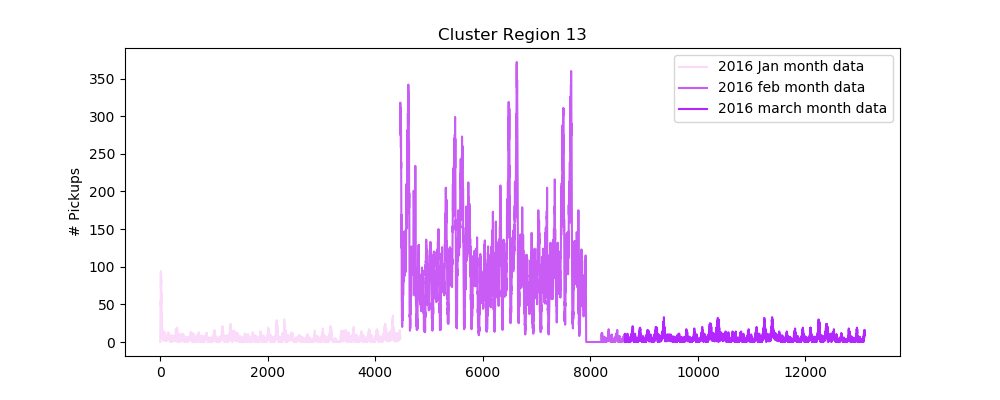

<IPython.core.display.Javascript object>


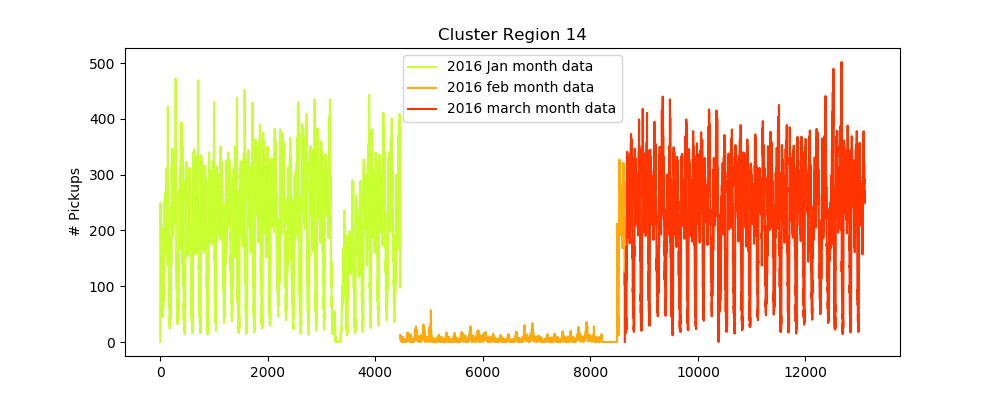

<IPython.core.display.Javascript object>


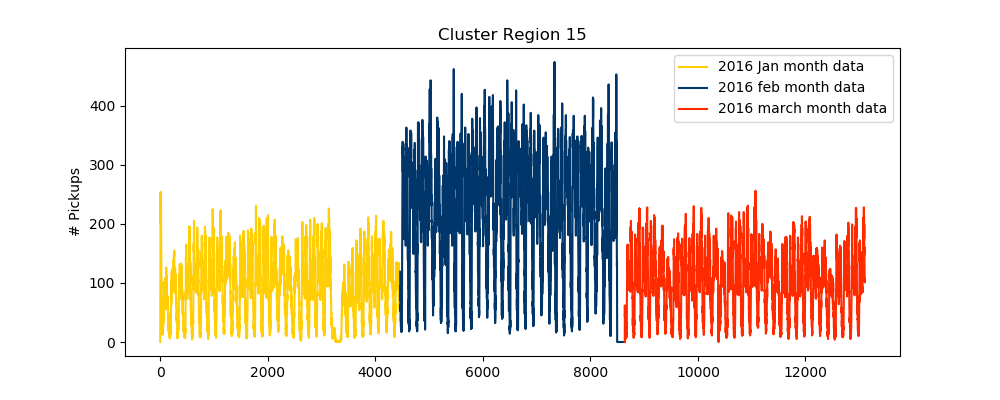

<IPython.core.display.Javascript object>


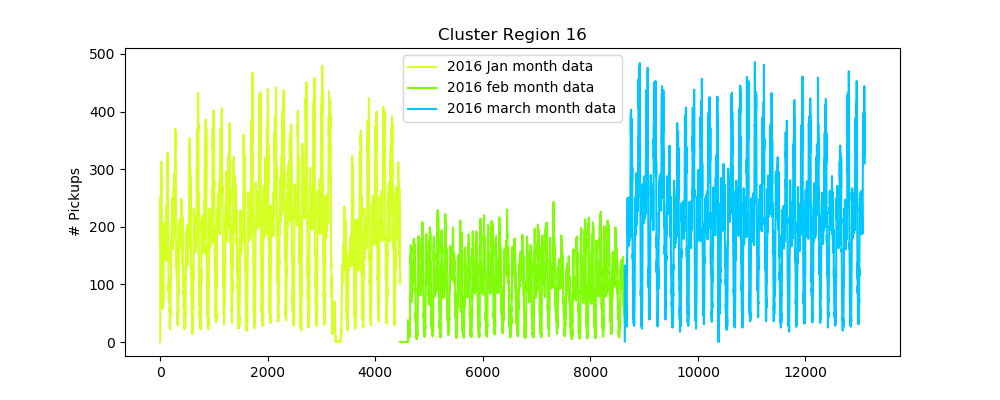

<IPython.core.display.Javascript object>


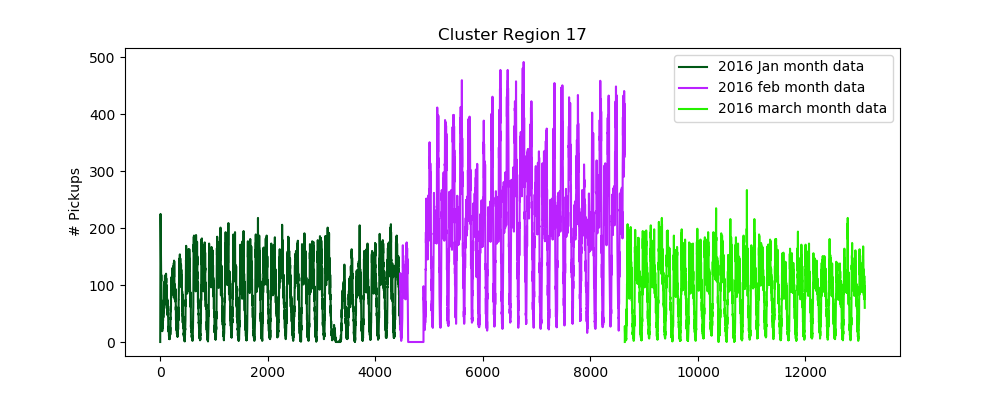

<IPython.core.display.Javascript object>


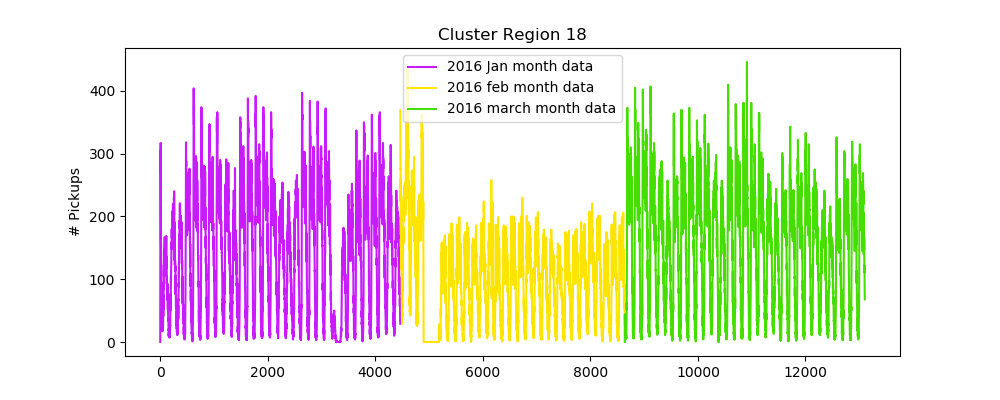

<IPython.core.display.Javascript object>


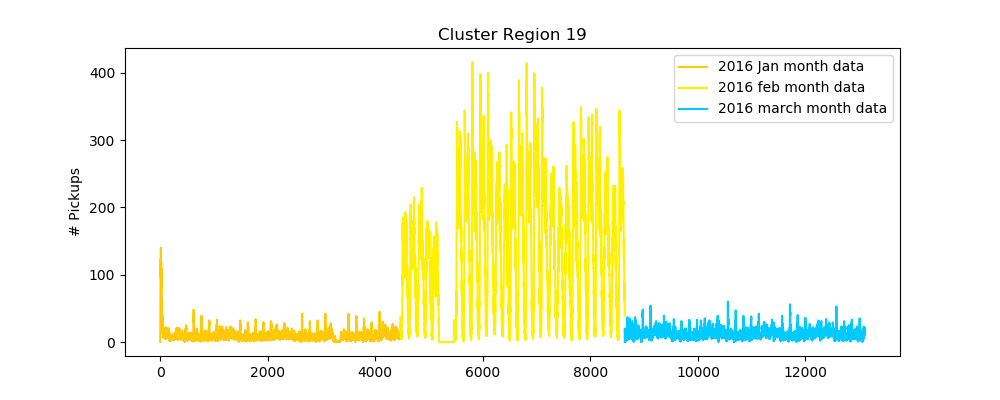

<IPython.core.display.Javascript object>


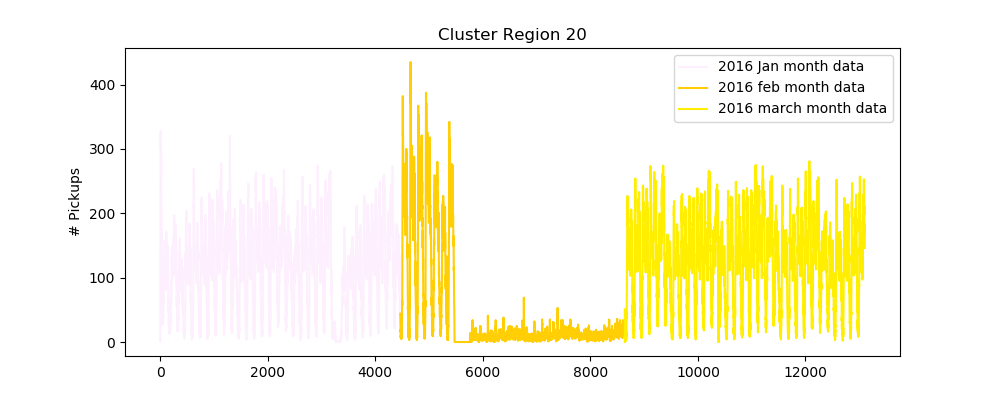

<IPython.core.display.Javascript object>


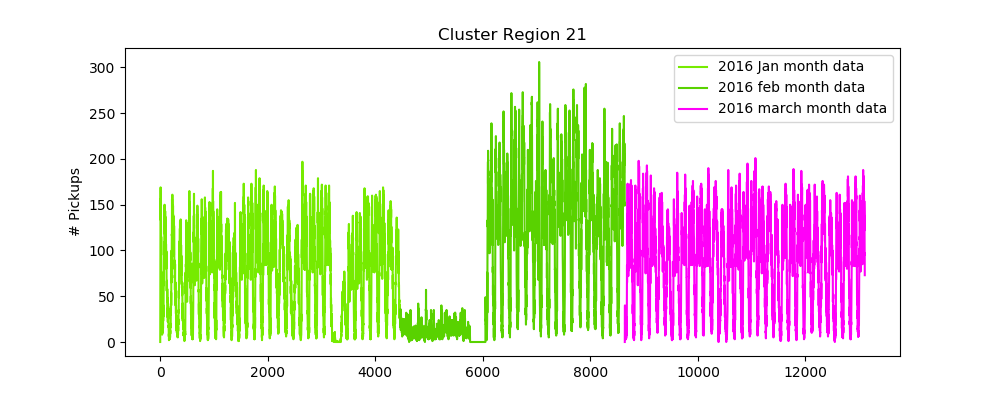

<IPython.core.display.Javascript object>


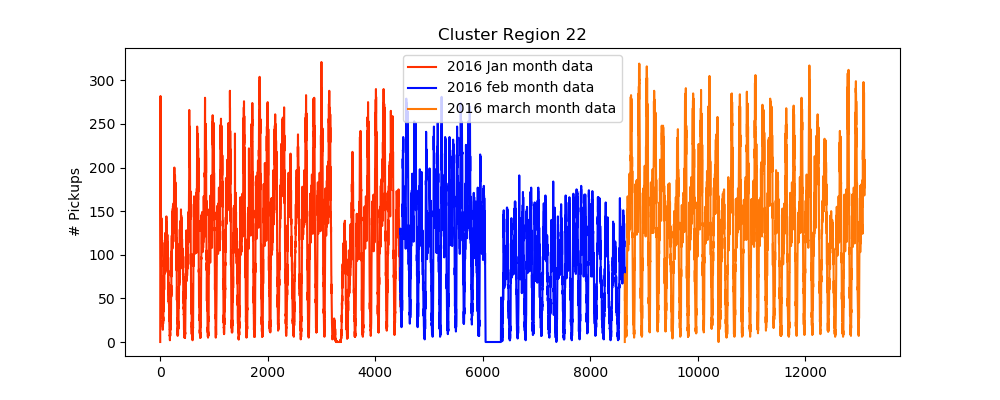

<IPython.core.display.Javascript object>


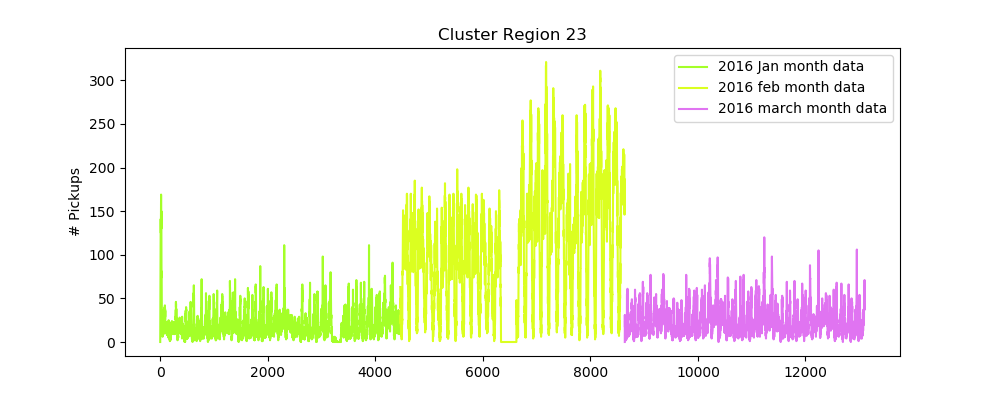

<IPython.core.display.Javascript object>


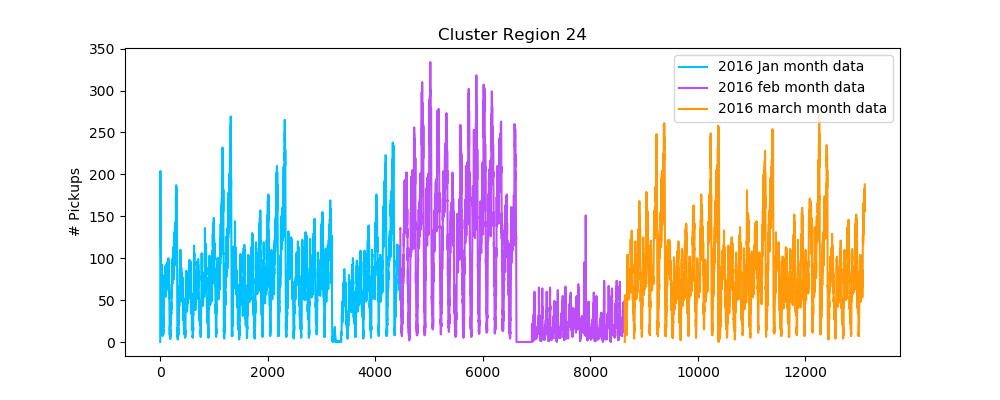

<IPython.core.display.Javascript object>


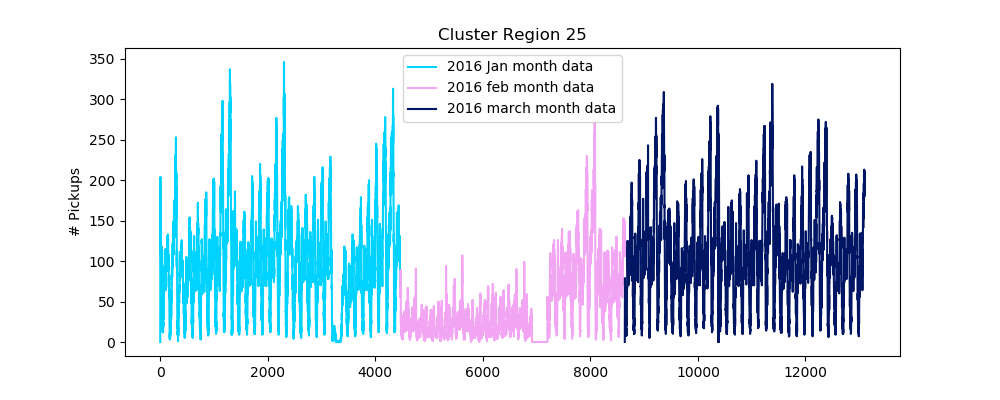

<IPython.core.display.Javascript object>


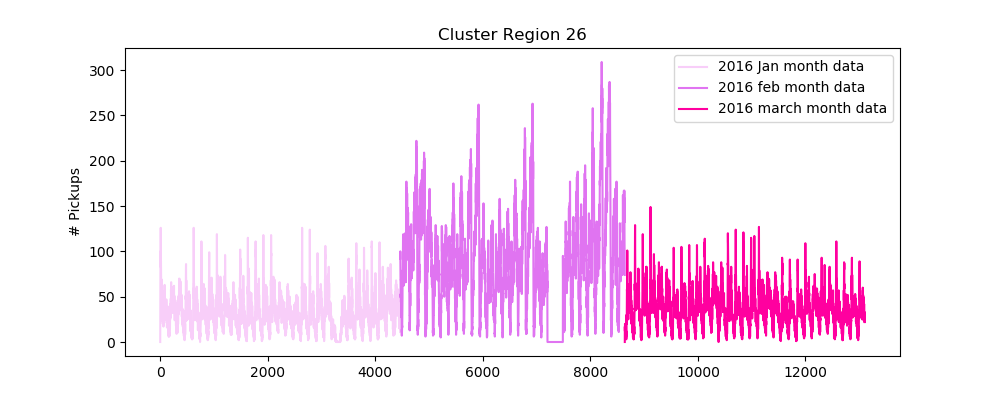

<IPython.core.display.Javascript object>


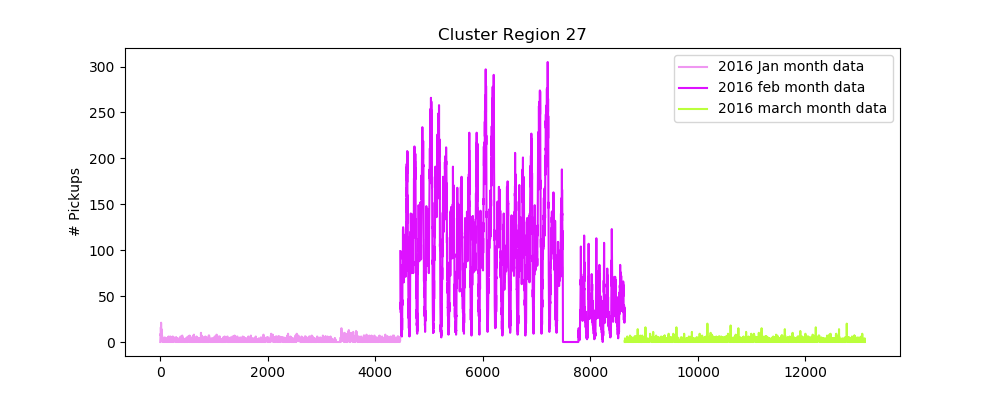

<IPython.core.display.Javascript object>


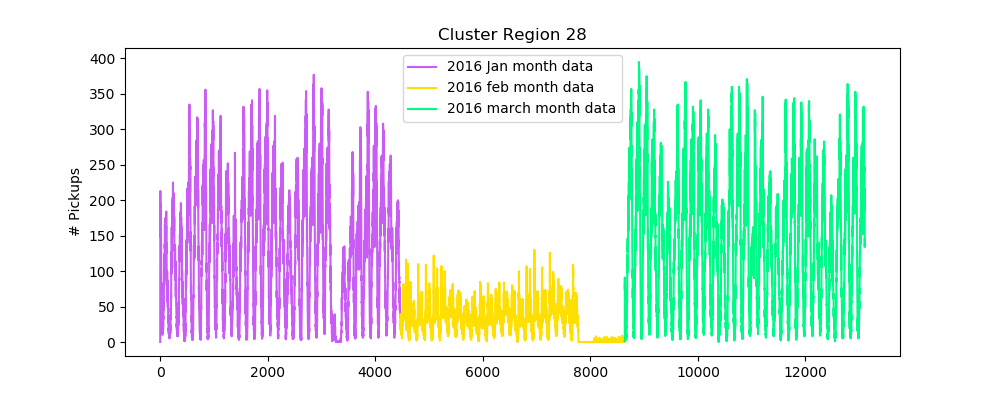

<IPython.core.display.Javascript object>


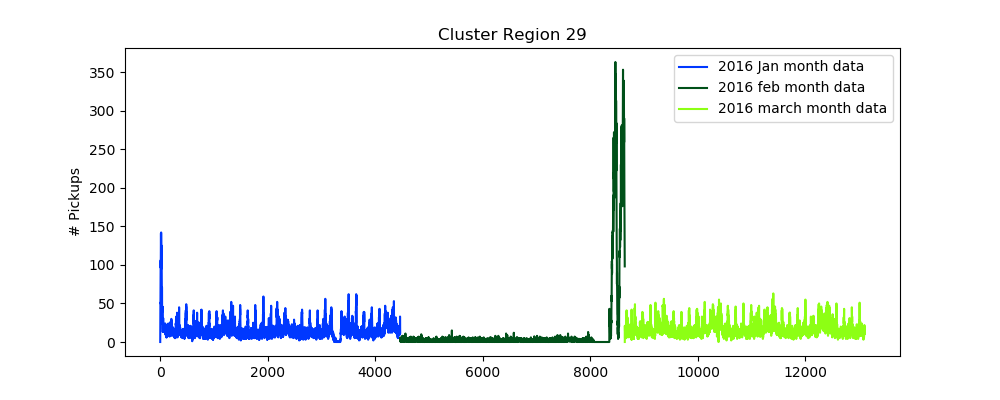

In [41]:
def uni_color():
    """There are better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))

for i in range(30):
    plt.figure(figsize=(10,4))
    plt.title("Cluster Region "+str(i))
    plt.ylabel("# Pickups")
    plt.plot(first_x, smooth16[i][:4464], color=uni_color(), label='2016 Jan month data')
    plt.plot(second_x, smooth16[i][4464:8640], color=uni_color(), label='2016 feb month data')
    plt.plot(third_x, smooth16[i][8640:], color=uni_color(), label='2016 march month data')
    plt.legend()
    plt.show()

Repeating patterns are present and Fourier Transformation could be useful to featurize.

### 7.7.2 Understanding how to featurize using fourier transformation

* **References used:** <br>
 - 'Time series feature extraction for data mining using DWT and DFT' by **Fabian Morchen**
 November 5, 2003
 - https://stackoverflow.com/questions/27546476/what-fft-descriptors-should-be-used-as-feature-to-implement-classification-or-cl<br>
 - https://dsp.stackexchange.com/questions/10062/when-should-i-calculate-psd-instead-of-plain-fft-magnitude-spectrum
 - https://en.wikipedia.org/wiki/Discrete_Fourier_transform <br>
 <br>
**Eigen vectors of DFT would be good for featurization but eigenvectors of DFT<br>
are complicated, not unique, and are the subject of ongoing research.**


* Discrete Fourier Transform(DFT) 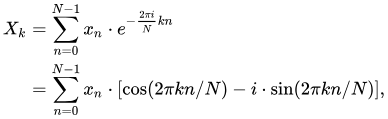 <br>
* DFT: Amplitude Spectrum 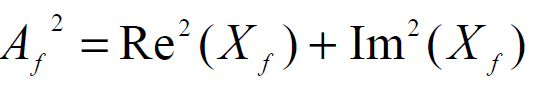
* Power spectral Density(PSD): absolute magnitude of the fourier transform squared.<br>
For example:
if signal is x[n], and its DFT is X(f), then the absolute magnitude of the DFT is |X(f)|, while the PSD is |X(f)|^2.

#### 7.7.2.1 Fourier Transform on 'jan_2016_smooth'

<b style= "color:#339966">Playing with 'jan_2016_smooth' one cluster to observe and understand, <br>
With the acquired understanding we design the required funtions<br>
And then we will use the function to properly featurize</b>

<br>
* Discrete Fourier Transform on processed data of Jan 2016 <br>
* observing 1 cluster only<br>
 Later we will do it for each of the 30 clusters separately with <br>
 all of jan,feb,march 2016 data which is in variable 'smooth16' <br>

<br>
* why discrete and not continous ?
 * we have 10min bins but each bin has a value associated with it, these values are discreate points 

In [41]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
# fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html

# FFT(fast fourier transform) is an algorithm that performs DFT

# amplitude value: np.fft returns complex values
Y  = np.fft.fft(np.array(jan_2016_smooth)[0:4460])

# frequency
freq = np.fft.fftfreq(4460, 1)
n = len(freq)

<IPython.core.display.Javascript object>


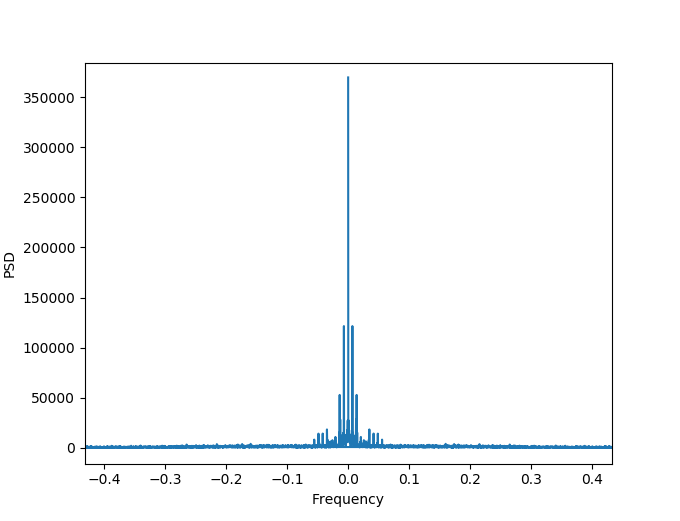

In [42]:
# ploting by taking PSD = absolute( complex valued amplitude)

plt.figure()
plt.plot( freq, np.abs(Y) )
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.show()

A[0] contains the zero-frequency term (the sum of the signal), which is always purely real for real inputs.<br>
A[1:n/2] contains the positive-frequency terms <br>
A[n/2+1:] contains the negative-frequency terms

#### 7.7.2.2  Process the frequency domain data

- To extract features we will take the amplitude peaks<br>
- Amplitude is symmetrically spread with x=0 as the reflecting surface<br>
- so each peak will be counted twice if we simply take peaks<br>
- hence we take only positive-frequency (n/2)terms
<br>
_Each Amplitude point actually captures the essence of the whole time spread_<br>
_hence a few top amplitude peaks can approximate the time series signal._ _

In [42]:

def process_freq(freq,Y1):
    '''The Amplitude spectrum in frequency domian is a complex space
       so take absolute values of amplitude i.e PSD.
       
       The amplitude values are symmetric with y axis acting as the mirror so half of the 
       frequency space is sufficient to record all the frequency peaks'''
    n = len(freq) # x is freq
    
    f = np.abs(freq)[:int(n/2)]
    a = np.abs(Y1)[:int(n/2)]
    
    return f,a

<IPython.core.display.Javascript object>


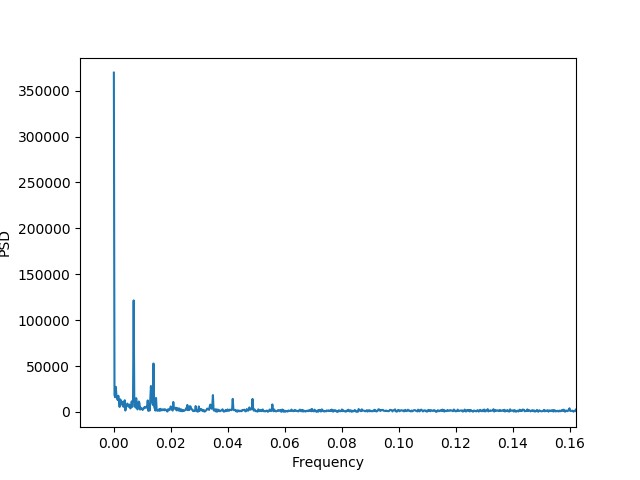

In [44]:
# plot the processed frequency data
# the plot has been zoomed near the origin

freq_val, amp_val = process_freq(freq,Y)

plt.figure()
plt.plot(freq_val, amp_val )
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.show()

The first peak at index 0, is the DC component,DC component just means the average of positive and negative half cycles is not zero. and that there is an offset <br>
<br>
For a time-varying sine wave:

x(t) = D + B.Sin(2.pi.f.t)

D is the DC component. It shifts the function up or down the y-axis. Note that it is independant of the function variable t.
<br>
we will not consider it's amplitude and frequency. We will start taking frequency and amplitudes from the second peak onwards.

#### 7.7.2.3  Extracting the peak amplitudes
<b style= "color:red">Simply sorting and taking the top values is a very bad idea, as explained in the figure below</b> 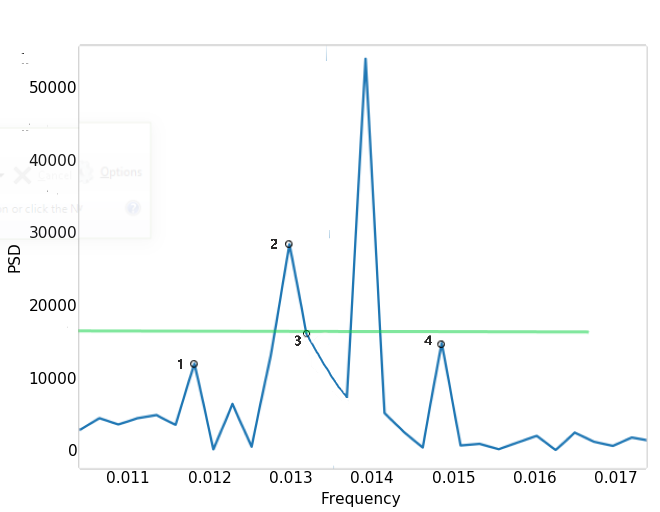
<br>
Point 3 will be taken as a peak(while it is not) and point 1 ,4 may missout if say we are choosing say top 5 peaks and point 3 has taken as the 5th spot

**_Extracting proper peaks_**<br>
https://peakutils.readthedocs.io/en/latest/tutorial_a.html

In [43]:

def gets_peaks(amp_val1,t):
    '''returns incices of the peaks'''
    indices = peakutils.indexes(amp_val1, thres=t, min_dist=1,thres_abs=True)
    return indices
   

<IPython.core.display.Javascript object>


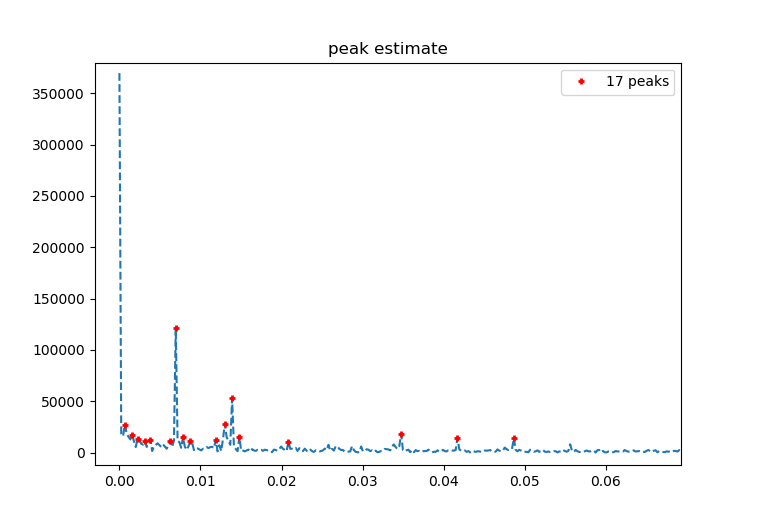

extracted peaks 
 [ 27367.97157122  17627.76169077  13700.55704091  11120.50183374
  12736.35052099  11611.15415846 121480.43094216  15014.09876928
  11378.54086474  12524.29155599  28268.31782723  52778.21466218
  15235.34931095  10843.91441909  18337.73661256  14240.92612957
  14162.91383201]


In [46]:
t1 = 10000 #threshold
ind = gets_peaks(amp_val,t1)

plt.figure()
pplot(freq_val, amp_val, ind)
plt.title('peak estimate')
plt.show() 

print('extracted peaks \n',amp_val[ind])

### 7.7.3  Fourier Transform Featurization on required data
With the help of the understanding acquired in the above section

In [44]:
#fft


def freqT(month_all):
    '''Discrete frequency transformation using fast fourier tranform'''
    '''Each cluster is transformed and processed separatly'''
    '''Returns top 5 amp and corresponding freq values for each cluster'''
    psd_y = []
    freq_x = []
    for clust_i in range(30):
        amp = np.fft.fft(month_all[i][:]) # returns complex values
        f = np.fft.fftfreq(1304,1)
        
        fre,ampli = process_freq(f,amp)
        
        t1=10000 # peak threshold
        peak_index = gets_peaks(ampli,t1)
        
        # sorting decending order , returns indices
        sorted_index = np.argsort(-(ampli[peak_index]))
        top5 = sorted_index[0:5]
        
        top5_amp = list(ampli[top5])
        top5_freq = list(fre[top5])
        
        psd_y.append(top5_amp)
        freq_x.append(top5_freq)
    return psd_y,freq_x


In [45]:
# 'psds' and 'frequencies' top 5 peak PSD values
# contains 30 lists corresponding to each cluster for 1st 3 months of 2016 data
# each of the 30 list is of size 5

psds,frequencies = freqT(smooth16)


In [46]:
print('number of clusters',len(psds))
print('num of top values',len(psds[0]))


number of clusters 30
num of top values 5


**_for each cluster the top 5 freq and amp/psd will be same_**

## 8  Modelling: 
### 8.1  Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

In [50]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [51]:
ratios_jan.head() 

Given  Prediction    Ratios
0     69           0  0.000000
1     69         106  1.536232
2    262         243  0.927481
3    311         299  0.961415
4    326         328  1.006135

In [52]:
# 30*4464 = 133920
ratios_jan.shape

(133920, 3)

### 8.1.1  Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [53]:
def MA_R_Predictions(ratios,month):
    
    '''simple_moving_average_ratios'''
    
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [54]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### 8.1.2  Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [55]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [56]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### 8.1.3  Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$ <br>
$R^′_t$ is the current predicted ratio.<br>
$R^′_{t-1}$ is the previous predicted ratio.<br>
$R_{t-1}$ is the actual previous ratio.<br>

In [57]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [58]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [59]:
mean_err=[0]*6
median_err=[0]*6
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [60]:
models_name =['Moving Averages (Ratios)','Moving Averages (2016 Values)',
              'Weighted Moving Averages (Ratios)','"Weighted Moving Averages (2016 Values)',
              'Exponential Moving Averages (Ratios)','Exponential Moving Averages (2016 Values)'] 

Error_baseModel = pd.DataFrame({'Model_name':models_name, 'MAPE':mean_err, 'MSE':median_err})

### 8.1.4  Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [61]:
Error_baseModel

Model_name      MAPE         MSE
0                   Moving Averages (Ratios)  0.162869  561.048798
1              Moving Averages (2016 Values)  0.126517  241.149014
2          Weighted Moving Averages (Ratios)  0.159966  548.528517
3    "Weighted Moving Averages (2016 Values)  0.121211  229.337343
4       Exponential Moving Averages (Ratios)  0.159340  546.586126
5  Exponential Moving Averages (2016 Values)  0.120964  226.037769

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## 8.2  Regression Models

### 8.2.1  Featurization


Preparing data to be split into train and test, The below prepares data in cumulative form<br>
which will be later split into test and train<br>
number of 10min indices for jan 2015= 24*31*60/10 = 4464<br>
number of 10min indices for jan 2016 = 24*31*60/10 = 4464<br>
number of 10min indices for feb 2016 = 24*29*60/10 = 4176<br>
number of 10min indices for march 2016 = 24*31*60/10 = 4464<br>
smooth16: it will contain 30 lists, each list will contain 4464+4176+4464=13104 values<br>
which represents the number of pickups <br>
that are happened for three months in 2016 data <br>


In [62]:
# print(len(smooth16))
# 30 i.e number of clusters/regions
# print(len(smooth16[0])) 
# 13104 i.e number of bins for 3 months
 
previous_bins = 5 # number of previous 10min intravels to consider    
    
###########################################################################################
# The following variables will be used to store 30 lists
# each internal list will store 13104-5= 13099 values
# Ex: [[cluster0 13099times],[cluster1 13099times], [cluster2 13099times].... 30 lists]
###########################################################################################

output = [] # to store number of pickups 13104-5 = 13099 for each cluster

lat = [] # stores 13099 lattitude values for every cluster

lon = [] # stores 13099 longitude values for every cluster

weekday = [] # stores day coded as sun= 0, mon=1, tue= 2, wed=3, thur=4, fri=5, sat=6

##########################################################################################



# its an numpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th bin
# the second row will have [f1,f2,f3,f4,f5]
# and so on...
ts_feature = [0]*previous_bins


for i in range(0,30):
    lat.append([kmeans.cluster_centers_[i][0]]*13099)
    lon.append([kmeans.cluster_centers_[i][1]]*13099)
    
    # jan 1st 2016 is Friday, so we start our day from 5: "(int(k/144))%7+5"
    # prediction start from 5th bin using previous 5 bins
    
    weekday.append([(((k//144)%7)+5)%7 for k in range(5,4464+4176+4464)])
    
    # smooth16 is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 30 lsits]
    ts_feature = np.vstack((ts_feature, [smooth16[i][r:r+previous_bins]\
                                             for r in range(0,len(smooth16[i])-previous_bins)]))
    output.append(smooth16[i][5:])
ts_feature = ts_feature[1:]

In [63]:
# sanity check
len(lat[0])*len(lat) == ts_feature.shape[0] == len(weekday)*len(weekday[0])== 30*13099 == len(output)*len(output[0])

True

#### 8.2.1.1   Add Exponential moving averages features
upto now we computed 8 features for every data point that starts from 50th min of the day
- 1. cluster center lattitude
- 2. cluster center longitude
- 3. day of the week 
- 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
- 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
- 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
- 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
- 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

From the baseline models we said the exponential weighted moving avarage gives us the best error<br>
We will try to add the same exponential weighted moving avarage at t as a feature to our data

In [64]:

# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 30 lsits]
predict_list = []
flat_exp_avg = []
for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= smooth16[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(smooth16[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

#### 8.2.1.2    Add Fourier Transform features

In [65]:
print(len(psds))
print(len(frequencies))
print(len(psds[0]))

30
30
5


In [66]:
 #frequencies and amplitudes are same for all the points a cluster
psd_feat = [0]*30
freq_feat = [0]*30

for cl in range(30):
    p_i = []
    f_i = []
    
    for k in range(13104):
        p_i.append(psds[cl])
        f_i.append(frequencies[cl])
    
    psd_feat[cl]=p_i
    freq_feat[cl]=f_i

### 8.2.2  Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

#### 8.2.2.1  Spliting

In [67]:
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


- _Last 5 bin Pickups Data_ 

In [68]:
# Extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [ts_feature[i*13099:(13099*i+9169)] for i in range(0,30)]

test_features = [ts_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [69]:
print("Train data # Regions = ",len(train_features), \
      "\nNumber of data points", len(train_features[0]), \
      "\n Each data point contains", len(train_features[0][0]),"features\n")

print("Test data # Regions = ",len(train_features), \
      "\nNumber of data points in test data", len(test_features[0]), \
      "\nEach data point contains", len(test_features[0][0]),"features")

Train data # Regions =  30 
Number of data points 9169 
 Each data point contains 5 features

Test data # Regions =  30 
Number of data points in test data 3930 
Each data point contains 5 features


In [70]:
# the above contains values in the form of list of lists (i.e. list of values of each region),
# here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
    
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [72]:
len(train_new_features)

275070

- _Fourier Transform features 9169 to train, 3930 to test_ 

In [73]:
train_fourier_psd = [psd_feat[i][5:9169+5] for i in range(30)]
test_fourier_psd = [psd_feat[i][9169+5:] for i in range(30)]

In [74]:
len(test_fourier_psd[24])

3930

In [75]:
train_fourier_freq = [freq_feat[i][5:9169+5] for i in range(30)]
test_fourier_freq = [freq_feat[i][9169+5:] for i in range(30)]

In [76]:
# converting lists of lists into single list i.e flatten
train_psds = sum(train_fourier_psd, [])
test_psds  = sum(test_fourier_psd, [])

train_freqs = sum(train_fourier_freq, [])
test_freqs   = sum(test_fourier_freq, [])

In [77]:
len(train_psds)

275070

- _Cluster center Coordinates(lattitude and longitude) data_ 

In [78]:
# 9169 to train

train_f_lat = [i[:9169] for i in lat]
train_f_lon = [i[:9169] for i in lon]
train_f_weekday = [i[:9169] for i in weekday]
train_f_output = [i[:9169] for i in output]
train_f_exp_avg = [i[:9169] for i in predict_list]

In [79]:
# 3930 points to test
test_f_lat = [i[9169:] for i in lat]
test_f_lon = [i[9169:] for i in lon]
test_f_weekday = [i[9169:] for i in weekday]
test_f_output = [i[9169:] for i in output]
test_f_exp_avg = [i[9169:] for i in predict_list]

In [80]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_lat = sum(train_f_lat, [])
train_lon = sum(train_f_lon, [])
train_weekday = sum(train_f_weekday, [])
train_output = sum(train_f_output, [])
train_exp_avg = sum(train_f_exp_avg,[])

In [81]:
# converting lists of lists into sinle list i.e flatten

test_lat = sum(test_f_lat, [])
test_lon = sum(test_f_lon, [])
test_weekday = sum(test_f_weekday, [])
test_output = sum(test_f_output, [])
test_exp_avg = sum(test_f_exp_avg, [])

#### 8.2.2.2  Preparing the data frame for our train data

In [82]:
train_FT = np.hstack((train_new_features, train_psds, train_freqs))
test_FT = np.hstack((test_new_features, test_psds,test_freqs))


In [83]:

columns = ['ft_5','ft_4','ft_3','ft_2','ft_1','P1','P2','P3','P4','P5',\
           'freq1','freq2','freq3','freq4','freq5']

df_train = pd.DataFrame(data=train_FT, columns=columns) 
df_train['lat'] = train_lat
df_train['lon'] = train_lon
df_train['weekday'] = train_weekday
df_train['exp_avg'] = train_exp_avg


print(df_train.shape)

(275070, 19)


#### 8.2.2.3 Preparing the data frame for our test data

In [84]:

df_test = pd.DataFrame(data=test_FT, columns=columns) 
df_test['lat'] = test_lat
df_test['lon'] = test_lon
df_test['weekday'] = test_weekday
df_test['exp_avg'] = test_exp_avg
print(df_test.shape)

(117900, 19)


In [85]:
df_test.head()

ft_5   ft_4   ft_3   ft_2   ft_1        P1           P2            P3  \
0  240.0  213.0  243.0  222.0  234.0  201924.0  50308.41553  47845.793418   
1  213.0  243.0  222.0  234.0  291.0  201924.0  50308.41553  47845.793418   
2  243.0  222.0  234.0  291.0  256.0  201924.0  50308.41553  47845.793418   
3  222.0  234.0  291.0  256.0  266.0  201924.0  50308.41553  47845.793418   
4  234.0  291.0  256.0  266.0  268.0  201924.0  50308.41553  47845.793418   

             P4           P5  freq1     freq2     freq3     freq4     freq5  \
0  50873.660713  33636.66781    0.0  0.000767  0.002301  0.001534  0.003067   
1  50873.660713  33636.66781    0.0  0.000767  0.002301  0.001534  0.003067   
2  50873.660713  33636.66781    0.0  0.000767  0.002301  0.001534  0.003067   
3  50873.660713  33636.66781    0.0  0.000767  0.002301  0.001534  0.003067   
4  50873.660713  33636.66781    0.0  0.000767  0.002301  0.001534  0.003067   

         lat        lon  weekday  exp_avg  
0  40.777809 -73.954054        5      231  
1  40.777809 -73.954054        5      273  
2  40.777809 -73.954054        5      261  
3  40.777809 -73.954054        5      264  
4  40.777809 -73.954054        5      266

In [86]:


pickle_out = open("df_train.pickle","wb")
pickle.dump(df_train, pickle_out)
pickle_out.close()

pickle_out = open("df_test.pickle","wb")
pickle.dump(df_test, pickle_out)
pickle_out.close()

pickle_out = open("train_output.pickle","wb")
pickle.dump(train_output, pickle_out)
pickle_out.close()

pickle_out = open("test_output.pickle","wb")
pickle.dump(test_output, pickle_out)
pickle_out.close()

In [2]:

pickle_in = open("df_train.pickle","rb")
df_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("df_test.pickle","rb")
df_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("train_output.pickle","rb")
train_output = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("test_output.pickle","rb")
test_output = pickle.load(pickle_in)
pickle_in.close()


#### 8.2.2.4  Hyper Parameter Optimization<br>

**GridSearch cv:** <br>
I didn't want to wait long periods of time by giving more number of values in lists to be used in Gridsearch.
Hence ran the GridSearch several times, each time adjusting the values in the list.<br>

Example: lets say we are tuning learning_rate, and max_iteration value <br>
So if we give lists like learning_rate= [10^i, for i =(-1 to -7)] <br>
and max_iter = [50,100,150,200,300,400,500]<br>
the model will have to run 7x7xnum_of_cv =49 times cv<br>
instead we run it several times and narrow down the range
1st time<br>
like learning_rate [10^i, i =(-1,-2,-3)] and max_iter = [50,100,500]    model runs 3x3x cv= 9x cv<br>
if best parameter returned is 10^-3 and max_iter is 500<br>
2nd time give<br>
learning_rate =[10^i, i = (-3,-5,-7)]  and max_iter = [450,500,600] model runs 9x cv<br>
if best parameter returned is 10^-3 and max_iter is 500<br>
we got our best parameters while running model for (9+9)x cv times only<br>


**RandomSearch cv:**<br>
learning_rate = [uniform_distribution ( (1*10^3) to (9*10^3) ) ]<br>

max_iter = [uniform_distribution (450 to 550)

In [112]:
# Store MAPE SCORES
train_mape=[0]*5
test_mape=[0]*5

In [113]:
# Base Line Model MAPE
train_mape[0]=(mean_absolute_error(train_output,df_train['ft_1'].values))/(sum(train_output)/len(train_output))
train_mape[1]=(mean_absolute_error(train_output,df_train['exp_avg'].values))/(sum(train_output)/len(train_output))

# Exponential Averages Forecasting MAPE
test_mape[0]= (mean_absolute_error(test_output, df_test['ft_1'].values))/(sum(test_output)/len(test_output))
test_mape[1]= (mean_absolute_error(test_output, df_test['exp_avg'].values))/(sum(test_output)/len(test_output))

### 8.2.3  Using Linear Regression

In [88]:

def LR_reg(df_train,df_test, train_output):
    s = StandardScaler()
    df_train1 = s.fit_transform(df_train)
    df_test1 = s.transform(df_test)
    
    LR = SGDRegressor(loss="squared_loss")
    
    
    alp =  [0.00001,0.000001,0.000002,0.000005]
    ite = [400,500,600]
    
    c_param = {"alpha": alp, "max_iter":ite}
    opti_model = GridSearchCV(LR, param_grid= c_param, scoring = "neg_mean_absolute_error",n_jobs=4, cv=3)
    
    opti_model.fit(df_train1, train_output)
    
    y_pred =  opti_model.best_estimator_.predict(df_train1)
    lr_train_predictions = [round(value) for value in y_pred]
    
    y_pred = opti_model.best_estimator_.predict(df_test1)
    lr_test_predictions = [round(value) for value in y_pred]
    
    print(opti_model.best_params_)
    return lr_train_predictions, lr_test_predictions

In [89]:
lr_train_predictions,lr_test_predictions = LR_reg(df_train,df_test, train_output)

{'alpha': 2e-06, 'max_iter': 500}

In [91]:
train_mape[2]= (mean_absolute_error(train_output, lr_train_predictions))/(sum(train_output)/len(train_output))
test_mape[2]= (mean_absolute_error(test_output, lr_test_predictions))/(sum(test_output)/len(test_output))
print(train_mape[2])
print(test_mape[2])

0.12067715876059297
0.11604329692762312


### 8.2.4  Using Random Forest Regressor

In [43]:
# Training a hyper-parameter tuned random forest regressor on our train data
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------


In [60]:
from scipy.stats import randint as sp_randint

def RF_reg(df_train,df_test,train_output):
    n_est = sp_randint(400,600)
    max_dep = sp_randint(10, 20)
    min_split = sp_randint(8, 15)
    start = [False]
    min_leaf = sp_randint(8, 15)
    c_param = {'n_estimators':n_est ,'max_depth': max_dep,'min_samples_split':min_split,\
               'min_samples_leaf':min_leaf ,'warm_start':start }
    
    RF_reg = RandomForestRegressor(max_features='sqrt', n_jobs=4)
    
    model2 =  RandomizedSearchCV(RF_reg, param_distributions= c_param, scoring = "neg_mean_absolute_error",n_jobs=4, cv=3)
    
    model2.fit(df_train, train_output)
    
    y_pred = model2.best_estimator_.predict(df_test)
    rndf_test_predictions = [round(value) for value in y_pred]
    y_pred = model2.best_estimator_.predict(df_train)
    rndf_train_predictions = [round(value) for value in y_pred]
    print(model2.best_params_)
    return rndf_train_predictions,rndf_test_predictions

In [95]:
# Predicting on test data using our trained random forest model 
rndf_train_predictions,rndf_test_predictions = RF_reg(df_train,df_test,train_output)

{'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 12,
 'n_estimators': 573,
 'warm_start': False}

In [101]:
train_mape[3]=(mean_absolute_error(train_output,rndf_train_predictions))/(sum(train_output)/len(train_output))
test_mape[3]= (mean_absolute_error(test_output, rndf_test_predictions))/(sum(test_output)/len(test_output))
print(train_mape[3])
print(test_mape[3])


0.11226526251987032
0.11320602165993218


### 8.2.5  Using XgBoost Regressor

In [106]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here
# http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------


def xg_reg(df_train,df_test,train_output):
    
    c_param={'learning_rate' :stats.uniform(0.01,0.2),
      'n_estimators':sp_randint(100,1000),
      'max_depth':sp_randint(1,10),
      'min_child_weight':sp_randint(1,8),
      'gamma':stats.uniform(0,0.02),
      'subsample':stats.uniform(0.6,0.4),
      'reg_alpha':sp_randint(0,200),
      'reg_lambda':stats.uniform(0,200),
      'colsample_bytree':stats.uniform(0.6,0.3)}
   
    xreg= xgb.XGBRegressor(nthread = 4)
    model3 = RandomizedSearchCV(xreg, param_distributions= c_param, scoring = "neg_mean_absolute_error", cv = 3)
    
    model3.fit(df_train, train_output)
    
    y_pred = model3.predict(df_test)
    xgb_test_predictions = [round(value) for value in y_pred]
    y_pred = model3.predict(df_train)
    xgb_train_predictions = [round(value) for value in y_pred]
    print(model3.best_params_)
    
    return xgb_train_predictions,xgb_test_predictions

In [107]:
# predicting with our trained Xg-Boost regressor

xgb_train_predictions,xgb_test_predictions=xg_reg(df_train,df_test,train_output)

{'colsample_bytree': 0.8196227008282665, 'gamma': 0.003537540472986178, 'learning_rate': 0.01938774261969011, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 932, 'reg_alpha': 96, 'reg_lambda': 29.25295663010847, 'subsample': 0.8655911706316048}


In [108]:
train_mape[4]=(mean_absolute_error(train_output, xgb_train_predictions))/(sum(train_output)/len(train_output))
test_mape[4]= (mean_absolute_error(test_output, xgb_test_predictions))/(sum(test_output)/len(test_output))
print(train_mape[4])
print(test_mape[4])

0.1143795691066153
0.11275302096036148


# 9  Error metric values for various models

In [123]:
models_name1=['Baseline Model','Exponential Averages Forecasting','Linear Regression','Random Forest Regression','XG_Boost'] 
train_mape2 =[x*100 for x in train_mape]
test_mape2 = [x*100 for x in test_mape]

Error_TreeModel1 = pd.DataFrame({'Model':models_name1, 'Train_MAPE %   ':train_mape2, 'Test_MAPE %   ':test_mape2})


print ("Error Metric Matrix -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
Error_TreeModel1

Error Metric Matrix -  MAPE
--------------------------------------------------------------------------------------------------------


Model  Train_MAPE %     Test_MAPE %   
0                    Baseline Model        12.477882       12.137217
1  Exponential Averages Forecasting        11.976904       11.613179
2                 Linear Regression        12.067716       11.604330
3          Random Forest Regression        11.226526       11.320602
4                          XG_Boost        11.437957       11.275302

MAPE% < 12.00 acheived<br>
Tree based models performed better
